# Project 3: APIs & NLP - Subreddit Predictions

## Problem Statement

Can we predict which posts came from the "Animal Crossing" and "The Sims" Subreddit?

With an increased rate of children spending time on entertainment devices, there are parental concerns on whether or not a game is appropriate for their children. Many popular games have Subreddit pages in which fans of said game post updates, gameplay and content. This makes Reddit a useful website on gaming information. 

A group of employees at Reddit came up with classification models to analyze and supervise Subreddits in order to make sure that posts are being posted on the correct Subreddit. Currently, Reddit has moderators “to help guide and create Reddit's many communities. Each Reddit community has its own focus, look, and rules, including what posts are on-topic there and how users are expected to behave [source](https://reddit.zendesk.com/hc/en-us/articles/204533859-What-s-a-moderator-#:~:text=A%20moderator%2C%20or%20a%20mod,users%20are%20expected%20to%20behave.&text=Add%20other%20redditors%20as%20moderators.).”

To improve the accuracy and automation of on-topic posts on Subreddit pages, the group of employees at Reddit will be building models and comparing two similar life-simulation games.

This project will be utilizing the Pushshift Reddit API to obtain the "Animal Crossing" and "The Sims” Subreddit pages from Reddit. The type of models that will be developed are Multinomial Naive Bayes, Random Forest, and Logistic Regression and will be evaluated based on the accuracy in which the model is able to predict whether or not the user's post comes from the Animal Crossing or Sims Subreddit page.

### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-&-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Preprocessing and Modeling](#Preprocessing-and-Modeling)
- [Evaluation and Conceptual Understanding](Evaluation-and-Conceptual-Understanding)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

## Background

With a growing rate in children playing video games, “it is important that parents understand how video games affect their children. Parents may not be aware of the actual scenes their children will experience in games before playing them. It’s crucial, therefore, that parents use ratings and related information that provides a detailed account of the violence, sex and language contained in a video game [Source](https://www.internetmatters.org/resources/online-gaming-advice/online-gaming-the-risks/#content)."

ESRB is the entertainment software rating board. “ESRB ratings provide information about what’s in a game or app so parents and consumers can make informed choices about which games are right for their family. Ratings have 3 parts: Rating Categories, Content Descriptors, and Interactive Elements [Source](https://www.esrb.org/)."


Animal Crossing is a game rated "E" for everyone. It is a simulation based game where players create their Animal Crossing character and simulate living on an island. The player can remodel their house, creating designs and home decorating, while exploring the outdoors by catching fish, hunting for bugs, and digging for fossils. Players also can build friendships with other Animal Crossing characters that have resemblance to anthropomorphic animals [Source](https://en.wikipedia.org/wiki/Animal_Crossing#Animal_Crossing:_New_Horizons_(2020).

Sims is a game rated "T" for Teen. The game is characterized as similar to Animal Crossing because it is a life simulation-based game where you create your character called a Sim. In Sims, you can also design your home, explore the outdoors and build relationships with other Sims. The game is “realistic” in that Sims are able to get jobs, earn money and pay bills, have hobbies and skills, and build relationships [Source](https://geekdad.com/2014/10/parents-should-know-about-the-sims-4/).


## Data Import & Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

#### Scraping Subreddits from API

In [2]:
# Function to gather posts from Subreddits
def scrape_subreddit(subreddit, num_posts):
    all_posts = []
    num_requests = num_posts // 100
    
    params = {
        'subreddit': subreddit,
        'size': 100,
    }
    
    url = 'https://api.pushshift.io/reddit/search/submission'
    
    for i in range(num_requests):
        res = requests.get(url, params)
        if res.status_code != 200:
            continue
        data = res.json()
        current_posts = data['data']
        all_posts.extend(current_posts)
        min_utc = min([post['created_utc'] for post in current_posts])
        params['before'] = min_utc
    
    return pd.DataFrame(all_posts)

#### Animal Crossing Dataframe

In [3]:
animal_crossing_df = scrape_subreddit('animalcrossing', 1110)
animal_crossing_df.head()

,all_awardings,allow_live_comments,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,...,author_cakeday,removed_by_category,crosspost_parent,crosspost_parent_list,media,media_embed,secure_media,secure_media_embed,banned_by,poll_data
0,[],False,ihavepolio,transparent,None,"[{'a': ':marina:', 'e': 'emoji', 'u': 'https:/...",bcd669be-ae08-11eb-91a5-0edf2864f40b,:marina:,dark,richtext,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,PlosoX,NaN,None,[],NaN,None,NaN,text,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,Altruistic_Size9003,NaN,None,[],NaN,None,NaN,text,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,PlosoX,NaN,None,[],NaN,None,NaN,text,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,OccasionUnfair8094,NaN,None,[],NaN,None,NaN,text,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Number of Unique `title`
animal_crossing_df['title'].nunique()

1068

#### The Sims Dataframe

In [5]:
# Utilizing Function to Scrape posts from The Sims
sims_df = scrape_subreddit('thesims', 1100)
sims_df.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,gallery_data,media_metadata,media,media_embed,secure_media,secure_media_embed,crosspost_parent,crosspost_parent_list,author_cakeday,banned_by
0,[],False,maplebuilds,None,[],None,text,t2_gehegqks,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,kaptingavrin,None,[],None,text,t2_o632q,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,No-Muffin9637,None,[],None,text,t2_8cjtqyd2,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,Murghana,None,"[{'a': ':moon:', 'e': 'emoji', 'u': 'https://e...",:moon:,richtext,t2_e3u12837,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Murghana,None,"[{'a': ':moon:', 'e': 'emoji', 'u': 'https://e...",:moon:,richtext,t2_e3u12837,False,False,...,"{'items': [{'id': 86189366, 'media_id': 'kmciz...","{'2x8afpgwslz71': {'e': 'Image', 'id': '2x8afp...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Number of Unique `title`
sims_df['title'].nunique()

986

Exploring/Cleaning Animal Crossing:

In [7]:
# Animal Crossing Dataframe with `subreddit`, `selftext`, and `title` columns
pd.set_option('display.max_columns', None)
animal_crossing = animal_crossing_df[['subreddit', 'selftext', 'title']]

In [8]:
animal_crossing.head()

,subreddit,selftext,title
0,AnimalCrossing,,The Legend of Coco: Twilight Princess
1,AnimalCrossing,,Star Trail &amp; Time-Lapse - ACNH-01 (Youtube...
2,AnimalCrossing,i have a genuine robust statue i got from redd...,why cant i donate art to blathers?
3,AnimalCrossing,,Star Trail &amp; Time-Lapse - ACNH-01 (Youtube...
4,AnimalCrossing,"Hi all, hoping something like this exists, but...",Help finding complete sortable items list


In [9]:
animal_crossing.shape

(1099, 3)

In [262]:
# To CSV
animal_crossing.to_csv('./datasets/animal_crossing.csv')

Exploring/Cleaning The Sims:

In [11]:
# Sims Dataframe with `subreddit`, `selftext`, and `title` columns
sims = sims_df[['subreddit', 'selftext', 'title']]

In [12]:
sims.shape

(1000, 3)

In [264]:
# To CSV
sims.to_csv('./datasets/sims.csv')

#### Merge Dataframes

In [13]:
subreddit = animal_crossing.append(sims, ignore_index=True)


In [14]:
subreddit.head()

,subreddit,selftext,title
0,AnimalCrossing,,The Legend of Coco: Twilight Princess
1,AnimalCrossing,,Star Trail &amp; Time-Lapse - ACNH-01 (Youtube...
2,AnimalCrossing,i have a genuine robust statue i got from redd...,why cant i donate art to blathers?
3,AnimalCrossing,,Star Trail &amp; Time-Lapse - ACNH-01 (Youtube...
4,AnimalCrossing,"Hi all, hoping something like this exists, but...",Help finding complete sortable items list


#### Dataframe to CSV

In [263]:
subreddit.to_csv('./datasets/subreddit_merged.csv')

### Cleaning

In [16]:
subreddit.dtypes

subreddit    object
selftext     object
title        object
dtype: object

In [17]:
subreddit.isnull().sum()

subreddit    0
selftext     2
title        0
dtype: int64

In [104]:
subreddit.shape

(2053, 8)

There seems to be only 2 null values, but when we look at the `selftext` column, there are a lot of blank rows and rows that say '[removed]'

In [18]:
# Filling null values with a space
subreddit['selftext'] = subreddit['selftext'].fillna('')

In [19]:
# selftext that is blank
subreddit[subreddit['selftext']=='']

,subreddit,selftext,title
0,AnimalCrossing,,The Legend of Coco: Twilight Princess
1,AnimalCrossing,,Star Trail &amp; Time-Lapse - ACNH-01 (Youtube...
3,AnimalCrossing,,Star Trail &amp; Time-Lapse - ACNH-01 (Youtube...
5,AnimalCrossing,,[Help] I don’t want them.
6,AnimalCrossing,,Daisy Mae at Brewster’s is the cutest!!
...,...,...,...
2093,thesims,,Happy day today. I have everything I need to c...
2094,thesims,,"Turns out, if you make a sim drink before the ..."
2095,thesims,,So out of boredom I gave the clients this room...
2097,thesims,,I paused at the right moment and was reminded ...


There are 1489 `selftext` rows that are blank. 1489/2053 is a lot of the dataframe as it consists or more than half of the rows.

In [20]:
subreddit[subreddit['selftext']=='[removed]']

,subreddit,selftext,title
20,AnimalCrossing,[removed],Recovering island from a damaged Switch?
22,AnimalCrossing,[removed],How do I get pigeon milk with my coffee?
23,AnimalCrossing,[removed],Question: Can you get Gyroids on a Nook Miles ...
26,AnimalCrossing,[removed],Anyone have their villager in boxes they don’t...
52,AnimalCrossing,[removed],Does anyone have any NMT to sell for bells?
...,...,...,...
2032,thesims,[removed],Is he handsome :)
2038,thesims,[removed],Rescuing sims from a CAS crash?
2069,thesims,[removed],mixing games features
2085,thesims,[removed],VLAD:Trick or Trite


There are 163 `selftext` rows that are [removed]. Combining the 163 [removed] rows with the blank `selftext` rows represents 1652/2053 of our rows missing from the `selftext` column.

#### Removing Duplicates

In [21]:
subreddit['title'].duplicated().value_counts()

False    2053
True       46
Name: title, dtype: int64

There are 46 duplicated posts, I will remove these because they are the exact same.

In [23]:
# Removing Duplicates with `title`
subreddit.drop_duplicates(subset='title', inplace=True)

#### Convert `subreddit` Features into Binary Labels

- 0: The Sims
- 1: Animal Crossing

In [24]:
# Create Label Column
subreddit['label'] = subreddit['subreddit'].map({'thesims':0, 'AnimalCrossing':1})

#Baseline
subreddit['label'].value_counts(normalize=True)

1    0.520214
0    0.479786
Name: label, dtype: float64

In [25]:
# Changing `selftext` row's with '[removed]' to blank
subreddit['selftext'] = subreddit['selftext'].replace('[removed]', '')
subreddit.head()

,subreddit,selftext,title,label
0,AnimalCrossing,,The Legend of Coco: Twilight Princess,1
1,AnimalCrossing,,Star Trail &amp; Time-Lapse - ACNH-01 (Youtube...,1
2,AnimalCrossing,i have a genuine robust statue i got from redd...,why cant i donate art to blathers?,1
4,AnimalCrossing,"Hi all, hoping something like this exists, but...",Help finding complete sortable items list,1
5,AnimalCrossing,,[Help] I don’t want them.,1


In [26]:
# New Column Combining `selftext` with `title`
subreddit['full_text'] = subreddit['title'] + ' ' + subreddit['selftext']

In [28]:
# Replacing '&amp;'
subreddit['full_text'] = subreddit['full_text'].replace('&amp;', '&', regex=True)

In [29]:
# Replacing URLs
subreddit['full_text'] = subreddit['full_text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

[Code Source](https://stackoverflow.com/questions/51994254/removing-url-from-a-column-in-pandas-dataframe/51994366)

### Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|subreddit|object|subreddit|Title of Subreddit|
|selftext|object|subreddit|Text in something|
|title|object|subreddit|Title of Reddit post|
|label|integer|subreddit|Subreddit into binary labels (Sims = 0 and Animal Crossing = 1)|
|full_text|object|subreddit|Selftext and Title columns combined|
|tokenized_sentences|object|subreddit|Tokenized sentences from full_text|
|full_text_length|integer|subreddit|Count of full_text characters|
|full_text_word_count|integer|subreddit|Word count for full_text|

### Tokenize

In [30]:
tokenizer = RegexpTokenizer('\s+', gaps=True)

In [31]:
subreddit['tokenized_sentences'] = subreddit['full_text'].str.lower().apply(tokenizer.tokenize)
subreddit['tokenized_sentences']

0            [the, legend, of, coco:, twilight, princess]
1       [star, trail, &, time-lapse, -, acnh-01, (yout...
2       [why, cant, i, donate, art, to, blathers?, i, ...
4       [help, finding, complete, sortable, items, lis...
5                         [[help], i, don’t, want, them.]
                              ...                        
2094    [turns, out,, if, you, make, a, sim, drink, be...
2095    [so, out, of, boredom, i, gave, the, clients, ...
2096    [i, was, watching, modern, family,, and, it, s...
2097    [i, paused, at, the, right, moment, and, was, ...
2098                                 [halloween, costume]
Name: tokenized_sentences, Length: 2053, dtype: object

## Exploratory Data Analysis

#### Summary Statistics:

In [33]:
subreddit.describe().T

,count,mean,std,min,25%,50%,75%,max
label,2053.0,0.520214,0.499713,0.0,0.0,1.0,1.0,1.0


In [34]:
# Column to Show Character Length
subreddit['full_text_length'] = subreddit['full_text'].apply(len)

In [35]:
# Column to Show Word Count
subreddit['full_text_word_count'] = subreddit['full_text'].str.split().apply(len)

In [36]:
# `tokenized_sentences` Top 5 Highest Word Count
subreddit['tokenized_sentences'].str.len().sort_values(ascending=False).head()

1574    1163
1219     776
304      549
1704     506
1732     493
Name: tokenized_sentences, dtype: int64

In [37]:
# `tokenized_sentences` Top 5 Shortest Word Count
subreddit['tokenized_sentences'].str.len().sort_values(ascending=True).head()

1664    0
278     1
309     1
922     1
613     1
Name: tokenized_sentences, dtype: int64

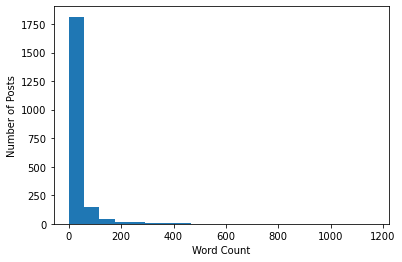

In [38]:
# Histogram of Word Count for `tokenized_sentences`
plt.hist(subreddit['tokenized_sentences'].str.len(), bins=20)
plt.ylabel('Number of Posts')
plt.xlabel('Word Count');

The histogram above shows that most posts range under 100 word count.

In [39]:
# `full_text` Top 5 Longest Length Count
subreddit['full_text_length'].sort_values(ascending=False).head()

1574    6782
1219    4248
1732    3129
304     2996
1704    2802
Name: full_text_length, dtype: int64

In [40]:
# `full_text` Top 5 Shortest Length Count
subreddit['full_text_word_count'].sort_values(ascending=True).head()

1664    0
278     1
309     1
922     1
613     1
Name: full_text_word_count, dtype: int64

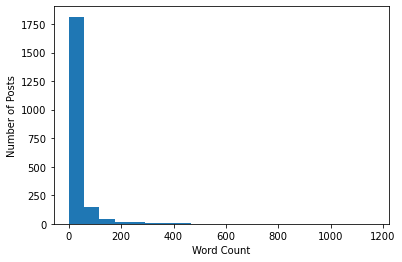

In [219]:
# Histogram of `full_text` Word Count
plt.hist(subreddit['full_text_word_count'], bins=20)
plt.ylabel('Number of Posts')
plt.xlabel('Word Count');

The above histogram represents the word count with number of posts. It seems like most posts are under 100 words, but because the scale of the x-axis is by 200, I decided to split the histogram into 2 and see if there are outliers.

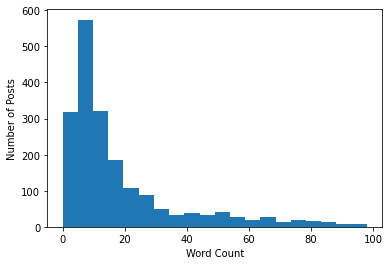

In [224]:
# Posts with Less Than 100 Words
word_count_below = subreddit[subreddit['full_text_word_count'] < 100]

# Plot with Less Than 100 Words
plt.hist(word_count_below['full_text_word_count'], bins=20)
plt.ylabel('Number of Posts')
plt.xlabel('Word Count');

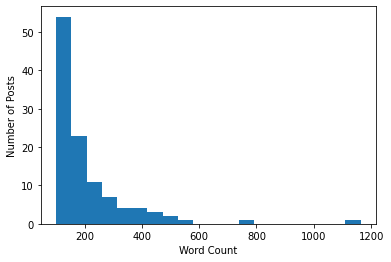

In [222]:
# Posts with More Than 100 Words
word_count_above = subreddit[subreddit['full_text_word_count'] > 100]

# Plot with More Than 100 Words
plt.hist(word_count_above['full_text_word_count'], bins=20)
plt.ylabel('Number of Posts')
plt.xlabel('Word Count');

The two histograms above are the word counts where count is split by numbers under 100 and numbers above 100 words. When we split the histograms. we can see that most posts are under 20 words.

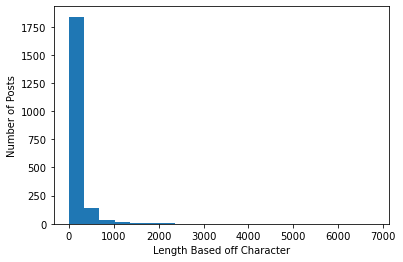

In [41]:
# Length of full_text
plt.hist(subreddit['full_text_length'], bins=20)
plt.ylabel('Number of Posts')
plt.xlabel('Length Based off Character');

The above histogram represents the length based off of character count with number of posts. It seems like most posts are under 500, but because the scale of the x-axis is by 1000, I decided to split the histogram into 2 to see if there are outliers.

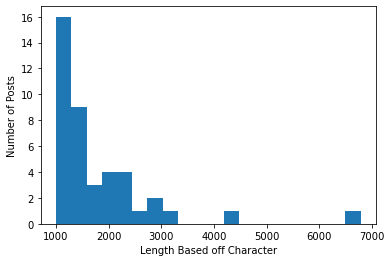

In [215]:
# Posts with More Than 1000 Characters
full_text_length_above_1000 = subreddit[subreddit['full_text_length'] > 1000]

# Plot with More Than 1000 Characters
full_text_length_above_1000 = subreddit[subreddit['full_text_length'] > 1000]
plt.hist(full_text_length_above_1000['full_text_length'], bins=20)
plt.ylabel('Number of Posts')
plt.xlabel('Length Based off Character');

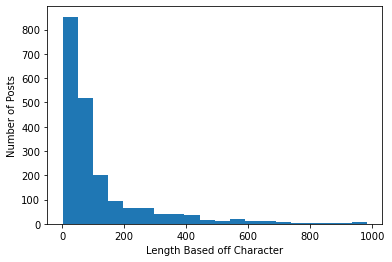

In [213]:
# Posts with Less Than 1000 Characters
full_text_length_under = subreddit[subreddit['full_text_length'] < 1000]

# Plot with Less Than 1000 Characters
plt.hist(full_text_length_under['full_text_length'], bins=20)
plt.ylabel('Number of Posts')
plt.xlabel('Length Based off Character');

The histograms above shows the length based off characters for `full_text`. Most posts are under 200 characters. I split the histogram into 2 to look at the outliers (posts above 3000) and to further look into the posts under 1000 characters. The histograms were split by posts over 1000 characters and under 1000 characters.

#### Groupby Subreddits

In [42]:
subreddit.groupby(['subreddit'])['full_text_word_count', 'full_text_length'].mean()

<ipython-input-42-caa094aa868a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  subreddit.groupby(['subreddit'])['full_text_word_count', 'full_text_length'].mean()


,full_text_word_count,full_text_length
subreddit,,
AnimalCrossing,20.390449,108.957865
thesims,37.624365,201.973604


When grouping by Subreddits, we see that The Sims Subreddit seems to have longer mean word count and more characters when compared to the Animal Crossing Subreddit.

#### Distribution Plot

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


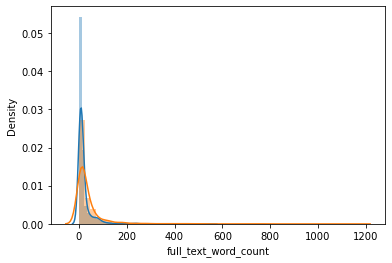

In [150]:
sns.distplot(subreddit[subreddit['subreddit'] == 'AnimalCrossing']['full_text_word_count'])
sns.distplot(subreddit[subreddit['subreddit'] == 'thesims']['full_text_word_count']);

#### Word Cloud

In [155]:
#Code Source: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

stop_words = ['Name', 'object', 'Length', 'title', 'dtype', 'full_text', 'tokenized_sentences'] + list(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=42)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

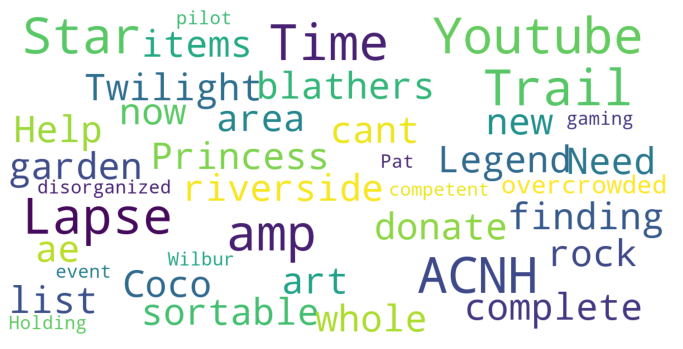

In [156]:
# Word Cloud for Animal Crossing
show_wordcloud(animal_crossing['title'])

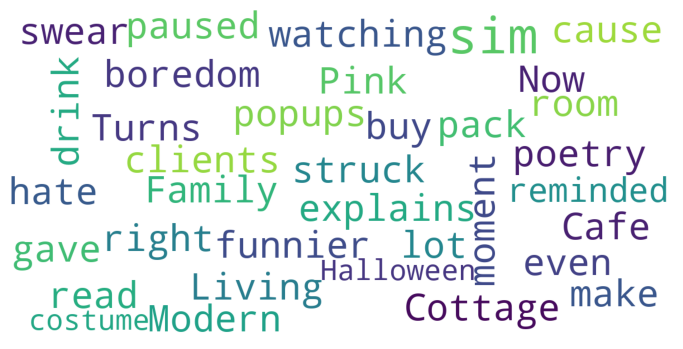

In [153]:
# Word Cloud for The Sims
show_wordcloud(sims['title'])

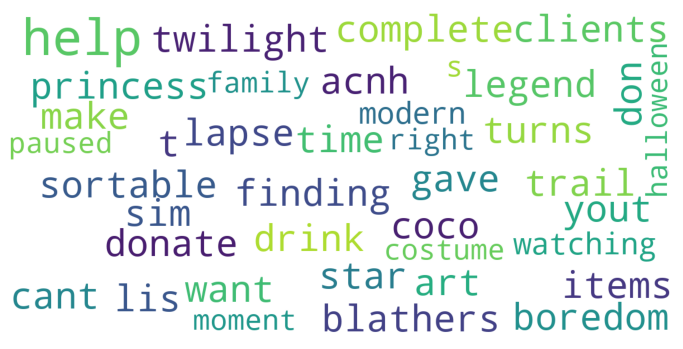

In [48]:
show_wordcloud(subreddit['tokenized_sentences'])

I made word clouds to visually see what words may stand out from the rest of the words. I made word clouds on individual Subreddits and the Subreddits combined.

## Preprocessing and Modeling

In [49]:
# Defining X and y
X = subreddit['full_text']
y = subreddit['label']

In [50]:
X.head()

0               The Legend of Coco: Twilight Princess 
1        Star Trail & Time-Lapse - ACNH-01 (Youtube:  
2    why cant i donate art to blathers? i have a ge...
4    Help finding complete sortable items list Hi a...
5                           [Help] I don’t want them. 
Name: full_text, dtype: object

In [51]:
# Split the data into the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state = 42)

In [363]:
# Baseline: Null Model
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

1    0.519455
0    0.480545
Name: label, dtype: float64

### Preprocessing

#### Count Vectorizer

In [158]:
# Instantiate a baseline CountVectorizer with only stop_words as hyperparameter
cvec = CountVectorizer(stop_words= 'english')

In [159]:
# Fit the Vectorizer
cvec.fit(X_train)

CountVectorizer(stop_words='english')

In [160]:
# Transform Corpus
X_train_countvec = cvec.transform(X_train)

In [168]:
X_train.head()

911                     My little farm next to my house. 
1052                        Making my European entrance! 
996     ♡ Build your castle from the rocks thrown at y...
439          Uhhhh, Kiki that’s a little inappropriate…. 
608     Just got Ione! The inside of her house is beau...
Name: full_text, dtype: object

In [162]:
X_train_countvec

<1539x5216 sparse matrix of type '<class 'numpy.int64'>'
	with 17914 stored elements in Compressed Sparse Row format>

In [163]:
# Sparse to Dense Representation
X_train_countvec.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

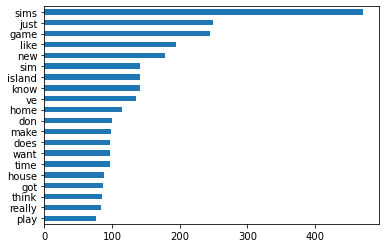

In [175]:
# Dataframe for CountVectorizer
subreddit_train_wordcount = pd.DataFrame(X_train_countvec.todense(), columns = cvec.get_feature_names())

# Transform test
X_test_countvec = cvec.transform(X_test)

# Bar Graph of Top 20 Words
subreddit_train_wordcount.sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh');

Above shows the top 20 words after utilizing the count vectorizer (no hyperparameters besides stop words were initiated).
We see that "sims" dominates the bar graph and has over 400 in word count.

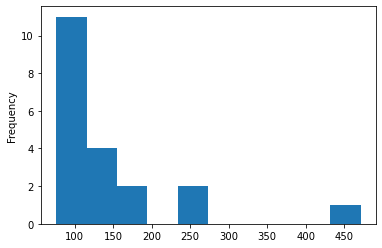

In [171]:
# Histogram of Top 20 Word Counts
subreddit_train_wordcount.sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='hist');

Above represents a histogram of the top 20 word count. We see that there are words at 450 that may be representative of an outlier.

In [290]:
# Code Source: https://app.neptune.ai/o/neptune-ml/org/eda-nlp-tools/n/2-0-top-ngrams-barchart-671a187d-c3b4-475a-bc9e-8aa6c937923b/c427446f-7b0e-4621-b791-47b0fd31a39e

def top_ngrams_barchart(text, n=2):
    stop_words = set(stopwords.words('english'))

    post = text.str.split() # Splitting text into string

    post = post.values.tolist() # List of lists
    
    corpus=[word for i in post for word in i] # Putting into 1 list
    
    def get_top_ngram(corpus, n=None):
        count_vec = CountVectorizer(ngram_range=(n, n)).fit(corpus) # Fit Count Vectorizer
        bag_of_words = count_vec.transform(corpus) # Transform Count Vectorizer
        sum_words = bag_of_words.sum(axis=0) # Sum of Transformed Count Vectorizer
        
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in count_vec.vocabulary_.items()] # Summing count of words based on #n
        
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) # Sorting based on highest # of word frequency
        return words_freq[:10] # Returning top 10

    top_n_bigrams= get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

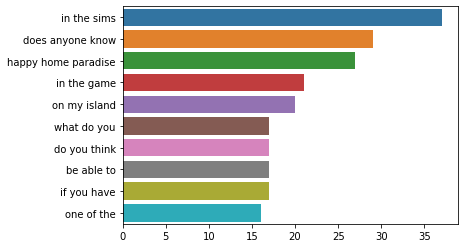

In [173]:
top_ngrams_barchart(subreddit['full_text'], 3)

Above is a barchart of tri-grams. This makes it easier to see visually what words/phrases are occuring multiple times. The most used trigram was “in the sims” which would correspond to the Sims. I also found “happy home paradise” and “on my island” to be useful phrases for Animal Crossing.

In [66]:
subreddit.reset_index(drop=True, inplace=True)

In [67]:
# Code Source: https://app.neptune.ai/neptune-ai/eda-nlp-tools/n/5-1-sentiment-barchart-1da2f77b-db4e-4636-b186-0328dcbb791b/ea6a3450-6d61-4b3f-9274-f1f0c241fa5c

def sentiment_vader(text, sent):
    sent_score = sent.polarity_scores(text)
    return max(sent_score, key=sent_score.get)

def plot_sentiment_barchart(text, method='Vader'):
    sent = SentimentIntensityAnalyzer()
    sentiment = text.map(lambda x: sentiment_vader(x, sent=sent))
    
    plt.bar(sentiment.value_counts().index,
            sentiment.value_counts())

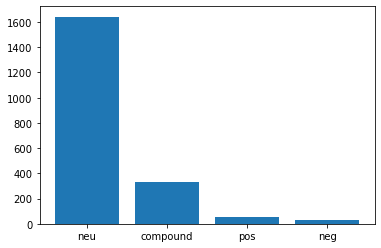

In [68]:
plot_sentiment_barchart(subreddit['full_text'], method='Vader')

Bar chart on frequency of sentiment analysis for each post in Subreddit Animal Crossing and The Sims. The bar chart shows that most posts are neutral.

In [69]:
# Instantiate Sentiment Analysis
sent = SentimentIntensityAnalyzer()

# Top 10 Negative Scores
polarity_scores = pd.DataFrame([sent.polarity_scores(subreddit['full_text'][i]) for i in range(len(subreddit['full_text']))])
polarity_scores['neg'].nlargest(n=10)

1882    0.683
1433    0.669
891     0.664
1787    0.649
1721    0.636
2001    0.632
266     0.629
1538    0.623
202     0.607
2006    0.605
Name: neg, dtype: float64

In [174]:
#Top 10 Negative Posts
print(subreddit['full_text'][1882])
print(subreddit['full_text'][1433])
print(subreddit['full_text'][891])
print(subreddit['full_text'][1787])
print(subreddit['full_text'][1721])
print(subreddit['full_text'][2001])
print(subreddit['full_text'][266])
print(subreddit['full_text'][1538])
print(subreddit['full_text'][202])
print(subreddit['full_text'][2006])

zodiac killer confirmed 
Uhm... I'm absolutely terrified. o_o 
No, no, NO! You are NOT Sasha! 
Grim be stylin' 
Sweater curse IRL 
TW: removing suicide option from extreme violence? 
Attack on Titan! 
Angry Keanu Reeves 
Oh no! My Pietro! He’s broken! 
i literally didn't do anything lol wtf 


Showing the top 10 negative polarity scores, we see that all scores are around .60. 7/10 negative posts are from The Sims Subreddit.

#### TF-IDF Vectorizer

In [292]:
# Instantiate TF-IDF Vectorizer
tvec = TfidfVectorizer(stop_words = 'english')

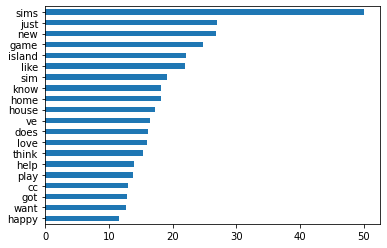

In [293]:
# Convert Training Data to Dataframe
X_train_tfidf = pd.DataFrame(tvec.fit_transform(X_train).todense(),
                          columns = tvec.get_feature_names())

# Bar Graph of Top 20 Words
X_train_tfidf.sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh');

### Modeling

#### Pipeline & Gridsearch: Count Vectorizer

In [294]:
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()), 
    ('mnb', MultinomialNB())
])

In [295]:
cross_val_score(pipe_cvec, X_train, y_train, cv=3).mean()

0.8336582196231319

In [296]:
pipe_cvec.fit(X_train, y_train)
print(f'Multinomial Naive Bayes (Count Vectorizer) Train Score: {pipe_cvec.score(X_train, y_train)}')
print(f'Multinomial Naive Bayes (Count Vectorizer) Test Score: {pipe_cvec.score(X_test, y_test)}')

Multinomial Naive Bayes (Count Vectorizer) Train Score: 0.9636127355425601
Multinomial Naive Bayes (Count Vectorizer) Test Score: 0.8287937743190662


In [297]:
# MNB Parameters
param_grid =  {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': [None, 'english'],
}

In [298]:
# Gridsearch MNB
mnb_gs = GridSearchCV(pipe_cvec, param_grid, cv=5, verbose=1)

In [299]:
# Fit GridSearch to Training Data
mnb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english']},
             verbose=1)

In [300]:
# Multinomial Naive Bayes (Count Vectorizer) Best Score
print(mnb_gs.best_score_)

0.8576970261009349


In [301]:
# Multinomial Naive Bayes (Count Vectorizer) Best Parameters
mnb_gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

Utilizing Count Vectorizer's Best Parameters:

In [302]:
# Count Vectorizer's Parameters
cvec_params = {'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

In [303]:
# Instantiate Count Vectorizer
cvec_final = CountVectorizer(cvec_params)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass input={'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'} as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [304]:
# Fit/Transform Train and Test
X_train_cvec = cvec_final.fit_transform(X_train)
X_test_cvec = cvec_final.transform(X_test)

In [305]:
# Count Vectorizer Best Score with Parameters
print(f'Multinomial Naive Bayes (Count Vectorizer) Train Score: {mnb_gs.score(X_train, y_train)}')
print(f'Multinomial Naive Bayes (Count Vectorizer) Test Score: {mnb_gs.score(X_test, y_test)}')

Multinomial Naive Bayes (Count Vectorizer) Train Score: 0.9317738791423001
Multinomial Naive Bayes (Count Vectorizer) Test Score: 0.8346303501945526


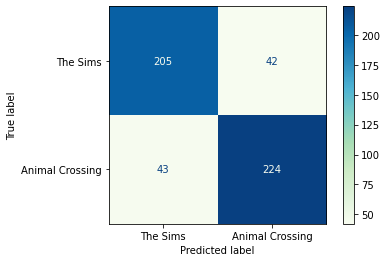

In [306]:
# Get Predictions
preds_cvec = mnb_gs.predict(X_test)

# Save Confusion Matrix Values
tn, fp, fn, tp = confusion_matrix(y_test, preds_cvec).ravel()

# Plot Confusion Matrix
plot_confusion_matrix(mnb_gs, X_test, y_test, cmap='GnBu', values_format='d', display_labels=['The Sims', 'Animal Crossing']);

In [307]:
print(f'Multinomial Naive Bayes (Count Vectorizer) Specificity: {tn / (tn + fp)}')
print(f'Multinomial Naive Bayes (Count Vectorizer) Sensitivity: {tp / (tp + fn)}')

Multinomial Naive Bayes (Count Vectorizer) Specificity: 0.8299595141700404
Multinomial Naive Bayes (Count Vectorizer) Sensitivity: 0.8389513108614233


#### Pipeline & Gridsearch: TF-IDF Vectorizer

In [308]:
# Multinomial Naive Bayes Pipeline
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [309]:
# Pipeline Parameters - TF-IDF Vectorizer
pipe_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000],
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}


In [310]:
# MNB Gridsearch
tvec_gs = GridSearchCV(pipe_tvec, pipe_tvec_params, cv=5, verbose=1)

In [311]:
# Fit Gridsearch
tvec_gs.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [312]:
# Multinomial Naive Bayes (TF-IDF Vectorizer) Best Parameters
tvec_gs.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 3000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [313]:
print(f'Multinomial Naive Bayes (TF-IDF Vectorizer) Train Score: {tvec_gs.score(X_train, y_train)}')
print(f'Multinomial Naive Bayes (TF-IDF Vectorizer) Test Score: {tvec_gs.score(X_test, y_test)}')

Multinomial Naive Bayes (TF-IDF Vectorizer) Train Score: 0.9558154645873944
Multinomial Naive Bayes (TF-IDF Vectorizer) Test Score: 0.8521400778210116


Utilizing IF-IDF Vectorizer's Best Parameters:

In [314]:
# TF-IDF Parameters
tvec_param = {'tvec__max_df': 0.9,
 'tvec__max_features': 2000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [315]:
# Instantiate TF-IDF Vectorizer
tvec_final = TfidfVectorizer(tvec_param)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass input={'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'} as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [316]:
# Fit/Transform Train and Test
X_train_tvec = tvec_final.fit_transform(X_train)
X_test_tvec = tvec_final.transform(X_test)

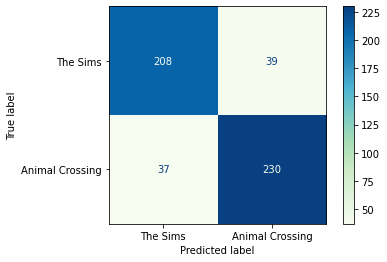

In [317]:
# Get Predictions
preds = tvec_gs.predict(X_test)

# Confusion Matrix Values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Plot Confusion Matrix
plot_confusion_matrix(tvec_gs, X_test, y_test, cmap='GnBu', values_format='d', display_labels=['The Sims', 'Animal Crossing']);

In [318]:
print(f'Multinomial Naive Bayes (TF-IDF Vectorizer) Specificity: {tn / (tn + fp)}')
print(f'Multinomial Naive Bayes (TF-IDF Vectorizer) Sensitivity: {tp / (tp + fn)}')

Multinomial Naive Bayes (TF-IDF Vectorizer) Specificity: 0.8421052631578947
Multinomial Naive Bayes (TF-IDF Vectorizer) Sensitivity: 0.8614232209737828


##### Predictions vs. Actual

In [319]:
y_test_mnb = pd.DataFrame(y_test.reset_index())
y_test_mnb['y_test_df_predicted'] = preds
y_test_mnb

,index,label,y_test_df_predicted
0,1262,0,0
1,1510,0,0
2,184,1,1
3,491,1,0
4,922,1,1
...,...,...,...
509,914,1,1
510,1027,1,1
511,1671,0,0
512,1335,0,0


In [320]:
y_test_mnb[y_test_mnb['y_test_df_predicted'] != y_test_mnb['label']]

,index,label,y_test_df_predicted
3,491,1,0
9,1391,0,1
10,907,1,0
16,10,1,0
22,2091,0,1
...,...,...,...
482,1905,0,1
489,472,1,0
495,1212,0,1
500,1790,0,1


In [362]:
print(subreddit['full_text'][491])
print(subreddit['full_text'][907])
print(subreddit['full_text'][10])
print(subreddit['full_text'][1905])
print(subreddit['full_text'][472])

A beach festival with Zucker and Octavian! 
Heres a few of my favorite homes I've made 
Made herringbone designs. If anyone else would like to use them, my code is MA-9511-4818-7469 
I want a medieval expansion for TS4 sooo bad 
Yeah, you could say that... 


Looking at the first 5 posts that were misclassified, I see that some of the posts may be too vague for the model to classify. For example, the first post ([491]) was classified as The Sims, but is from Animal Crossing. Because there are so many characters in Animal Crossing, the model may not have picked up on "Zucker" and "Octavian", but perhaps beach and festival which could pertain to both Subreddits.

#### Random Forest

##### Count Vectorizer

In [381]:
# Instantiate Random Forest
rf_c = RandomForestClassifier()

# Fit Random Forest
rf_c.fit(X_train_cvec, y_train)

# Random Forest Score
print(f'Random Forest Train Score: {rf_c.score(X_train_cvec, y_train)}')
print(f'Random Forest Test Score: {rf_c.score(X_test_cvec, y_test)}')
print(f'Random Forest Accuracy Score: {accuracy_score(y_test, rf_c_preds)}')

Random Forest Train Score: 0.9993502274204028
Random Forest Test Score: 0.77431906614786
Random Forest Accuracy Score: 0.7665369649805448


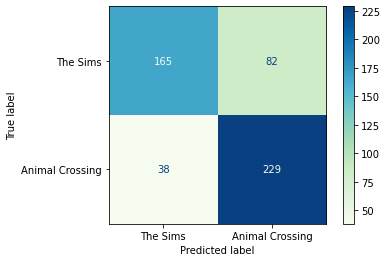

In [323]:
# Random Forest (Count Vectorizer) Predictions
rf_c_preds = rf_c.predict(X_test_cvec)

# Confusion Matrix Values 
tn, fp, fn, tp = confusion_matrix(y_test, rf_c_preds).ravel()

# Plot Confusion Matrix
plot_confusion_matrix(rf_c, X_test_cvec, y_test, cmap='GnBu', values_format='d', display_labels=['The Sims', 'Animal Crossing']);

In [324]:
print(f'Count Vectorizer Specificity: {tn / (tn + fp)}')
print(f'Count Vectorizer Sensitivity: {tp / (tp + fn)}')

Count Vectorizer Specificity: 0.6680161943319838
Count Vectorizer Sensitivity: 0.8576779026217228


#### Gridsearch Random Forest (Count Vectorizer)

In [366]:
rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1,2,3,4,5],
    'max_features': ['auto', 'sqrt']
}

rf_gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
rf_gs.fit(X_train_cvec, y_train)
print(rf_gs.best_score_)
rf_gs.best_params_

0.8050509750835484


{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [377]:
print(f'Random Forest (Count Vectorizer) Train Score: {rf_gs.score(X_train_cvec, y_train)}')
print(f'Random Forest (Count Vectorizer) Test Score: {rf_gs.score(X_test_cvec, y_test)}')

Random Forest (Count Vectorizer) Train Score: 0.9057829759584145
Random Forest (Count Vectorizer) Test Score: 0.7782101167315175


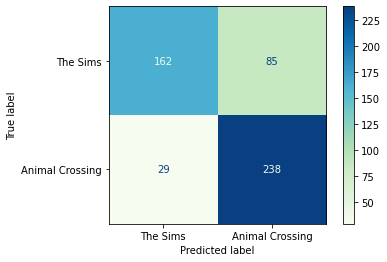

In [369]:
# Random Forest (Count Vectorizer) Gridsearch Predictions
rf_preds = rf_gs.predict(X_test_cvec)

# Confusion Matrix Values 
tn, fp, fn, tp = confusion_matrix(y_test, rf_preds).ravel()

# Plot Confusion Matrix
plot_confusion_matrix(rf_gs, X_test_cvec, y_test, cmap='GnBu', values_format='d', display_labels=['The Sims', 'Animal Crossing']);

In [370]:
print(f'Count Vectorizer Specificity: {tn / (tn + fp)}')
print(f'Count Vectorizer Sensitivity: {tp / (tp + fn)}')

Count Vectorizer Specificity: 0.6558704453441295
Count Vectorizer Sensitivity: 0.8913857677902621


##### TF-IDF Vectorizer

In [380]:
# Fit Random Forest
rf_c.fit(X_train_tvec, y_train)

# Random Forest Score
print(f'Random Forest Train Score: {rf_c.score(X_train_tvec, y_train)}')
print(f'Random Forest Test Score: {rf_c.score(X_test_tvec, y_test)}')
print(f'Random Forest Accuracy Score: {accuracy_score(y_test, rf_preds)}')

Random Forest Train Score: 0.9993502274204028
Random Forest Test Score: 0.745136186770428
Random Forest Accuracy Score: 0.7782101167315175


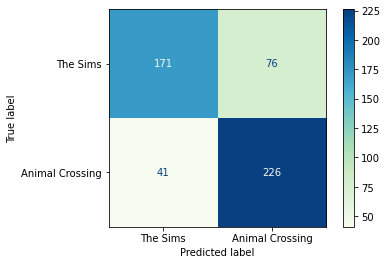

In [326]:
rf_preds = rf_c.predict(X_test_tvec)

# Confusion Matrix Values 
tn, fp, fn, tp = confusion_matrix(y_test, rf_preds).ravel()

# Plot Confusion Matrix
plot_confusion_matrix(rf_c, X_test_tvec, y_test, cmap='GnBu', values_format='d', display_labels=['The Sims', 'Animal Crossing']);

In [327]:
print(f'Count Vectorizer Specificity: {tn / (tn + fp)}')
print(f'Count Vectorizer Sensitivity: {tp / (tp + fn)}')

Count Vectorizer Specificity: 0.6923076923076923
Count Vectorizer Sensitivity: 0.846441947565543


#### Random Forest (TF-IDF Vectorizer) Gridsearch

In [371]:
rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1,2,3,4,5],
    'max_features': ['auto', 'sqrt']
}

rf_gs_tvec = GridSearchCV(rf, param_grid=rf_params, cv=5)
rf_gs_tvec.fit(X_train_tvec, y_train)
print(rf_gs_tvec.best_score_)
rf_gs_tvec.best_params_

0.810903591522484


{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 300}

In [378]:
print(f'Random Forest (TF-IDF Vectorizer) Train Score: {rf_gs_tvec.score(X_train_tvec, y_train)}')
print(f'Random Forest (TF-IDF Vectorizer) Test Score: {rf_gs_tvec.score(X_test_tvec, y_test)}')

Random Forest (TF-IDF Vectorizer) Train Score: 0.9993502274204028
Random Forest (TF-IDF Vectorizer) Test Score: 0.7645914396887159


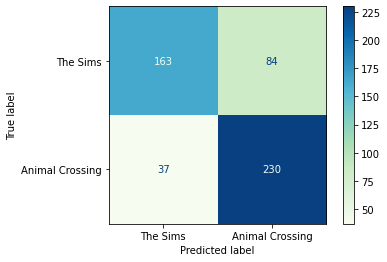

In [375]:
# Random Forest (TF-IDF Vectorizer) Gridsearch Predictions
rf_tvec_preds = rf_gs_tvec.predict(X_test_tvec)

# Confusion Matrix Values 
tn, fp, fn, tp = confusion_matrix(y_test, rf_tvec_preds).ravel()

# Plot Confusion Matrix
plot_confusion_matrix(rf_gs_tvec, X_test_tvec, y_test, cmap='GnBu', values_format='d', display_labels=['The Sims', 'Animal Crossing']);

In [379]:
print(f' Random Forest (TF-IDF Vectorizer) Specificity: {tn / (tn + fp)}')
print(f'Random Forest (TF-IDF Vectorizer) Sensitivity: {tp / (tp + fn)}')

 Random Forest (TF-IDF Vectorizer) Specificity: 0.659919028340081
Random Forest (TF-IDF Vectorizer) Sensitivity: 0.8614232209737828


#### Logistic Regression

##### Count Vectorizer

In [328]:
# Fit/Transform Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [329]:
# Instantiate Logistic Regression
logreg = LogisticRegression()

# Fit Logistic Regression
logreg.fit(X_train_cvec, y_train)

# Cross Validation Score
cross_val_score(logreg, X_train_cvec, y_train).mean()

0.8226067092516605

In [330]:
print(f'Logistic Regression (Count Vectorizer) Train Score: {logreg.score(X_train_cvec, y_train)}')
print(f'Logistic Regression (Count Vectorizer) Test Score: {logreg.score(X_test_cvec, y_test)}')

Logistic Regression (Count Vectorizer) Train Score: 0.9798570500324886
Logistic Regression (Count Vectorizer) Test Score: 0.8132295719844358


In [331]:
# Logistic Regression (Count Vectorizer Predictions)
preds_log_cvec = logreg.predict(X_test_cvec)

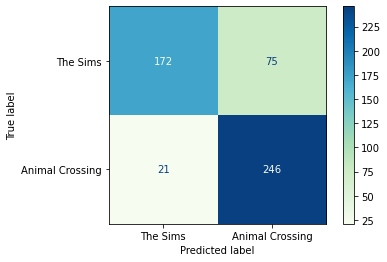

In [332]:
# Confusion Matrix Values 
tn, fp, fn, tp = confusion_matrix(y_test, preds_log_cvec).ravel()

# Plot Confusion Matrix
plot_confusion_matrix(logreg, X_test_cvec, y_test, cmap='GnBu', values_format='d', display_labels=['The Sims', 'Animal Crossing']);

In [333]:
print(f'Count Vectorizer Specificity: {tn / (tn + fp)}')
print(f'Count Vectorizer Sensitivity: {tp / (tp + fn)}')

Count Vectorizer Specificity: 0.6963562753036437
Count Vectorizer Sensitivity: 0.9213483146067416


#### Logistic Regression (Count Vectorizer) Gridsearch:

In [334]:
# Pipeline & Gridsearch Logisitc Regression (Count Vectorizer)
logreg_pipe = Pipeline([
    ('logreg', LogisticRegression(solver='liblinear'))
])

logreg_param = {
    'logreg__C': np.logspace(-5, 1, 100),
    'logreg__penalty': ['l1', 'l2']
}

logreg_gs = GridSearchCV(logreg_pipe, logreg_param, verbose=1)
logreg_gs.fit(X_train_cvec, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logreg__C': array([1.00000000e-05, 1.14975700e-05, 1.32194115e-05, 1.51991108e-05,
       1.74752840e-05, 2.00923300e-05, 2.31012970e-05, 2.65608778e-05,
       3.05385551e-05, 3.51119173e-05, 4.03701726e-05, 4.64158883e-05,
       5.33669923e-05, 6.13590727e-05, 7.05480231e-05, 8.1...
       4.03701726e-01, 4.64158883e-01, 5.33669923e-01, 6.13590727e-01,
       7.05480231e-01, 8.11130831e-01, 9.32603347e-01, 1.07226722e+00,
       1.23284674e+00, 1.41747416e+00, 1.62975083e+00, 1.87381742e+00,
       2.15443469e+00, 2.47707636e+00, 2.84803587e+00, 3.27454916e+00,
       3.76493581e+00, 4.32876128e+00, 4.97702356e+00, 5.72236766e+00,
       6.57933225e+00, 7.56463328e+00, 8.69749003e+00, 1.00000000e+01]),
                         'logreg__penalty': ['l1', 'l2']},
             verbose=1)

In [335]:
print(f'Logisitc Regression Count Vectorizer Best Score: {logreg_gs.best_score_}')
print(f'Logisitc Regression Count Vectorizer Train Score: {logreg_gs.score(X_train_cvec, y_train)}')
print(f'Logisitc Regression Count Vectorizer Test Score: {logreg_gs.score(X_test_cvec, y_test)}')
print(f'Logisitc Regression Count Vectorizer Best Parameters: {logreg_gs.best_params_}')

Logisitc Regression Count Vectorizer Best Score: 0.825206226997758
Logisitc Regression Count Vectorizer Train Score: 0.9948018193632229
Logisitc Regression Count Vectorizer Test Score: 0.8132295719844358
Logisitc Regression Count Vectorizer Best Parameters: {'logreg__C': 1.873817422860383, 'logreg__penalty': 'l2'}


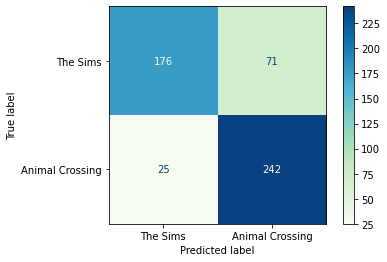

In [336]:
# Get Predictions
preds_log_cvec = logreg_gs.predict(X_test_cvec)

# Save Confusion Matrix Values
tn, fp, fn, tp = confusion_matrix(y_test, preds_log_cvec).ravel()

# Plot Confusion Matrix
plot_confusion_matrix(logreg_gs, X_test_cvec, y_test, cmap='GnBu', values_format='d', display_labels=['The Sims', 'Animal Crossing']);

In [337]:
print(f'Logistic Regression (Count Vectorizer Specificity): {tn / (tn + fp)}')
print(f'Logistic Regression (Count Vectorizer Sensitivity): {tp / (tp + fn)}')

Logistic Regression (Count Vectorizer Specificity): 0.7125506072874493
Logistic Regression (Count Vectorizer Sensitivity): 0.9063670411985019


##### TF-IDF Vectorizer

In [358]:
# Instantiate Logistic Regression with Gridsearch Parameters from CVEC
logreg_tvec = LogisticRegression(C=1.873817422860383, penalty='l2', solver='liblinear')
logreg_tvec.fit(X_train_tvec, y_train)

cross_val_score(logreg, X_train_tvec, y_train).mean()

0.8187000296120818

In [359]:
print(f'Logistic Regression TF-IDF Train Score: {logreg.score(X_train_tvec, y_train)}')
print(f'Logistic Regression TF-IDF Test Score: {logreg.score(X_test_tvec, y_test)}')

Logistic Regression TF-IDF Train Score: 0.7348927875243665
Logistic Regression TF-IDF Test Score: 0.6673151750972762


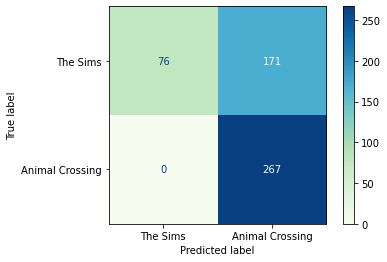

In [355]:
# Confusion Matrix Values 
tn, fp, fn, tp = confusion_matrix(y_test, preds_log_tvec).ravel()

# Plot Confusion Matrix
plot_confusion_matrix(logreg, X_test_tvec, y_test, cmap='GnBu', values_format='d', display_labels=['The Sims', 'Animal Crossing']);

In [356]:
print(f'TF-IDF Vectorizer Specificity: {tn / (tn + fp)}')
print(f'TF-IDF Vectorizer Sensitivity: {tp / (tp + fn)}')

TF-IDF Vectorizer Specificity: 0.7408906882591093
TF-IDF Vectorizer Sensitivity: 0.8689138576779026


|Model|Train Score|Test Score|
|---|---|---|
|Multinomial Bayes (Count Vectorizer)|0.937|0.852|
|Multinomial Bayes (TF-IDF Vectorizer)|0.959|0.881|
|Random Forest (Count Vectorizer)|0.999|0.764|
|Random Forest (TF-IDF Vectorizer|0.999|0.761|
|Logistic Regression (Count Vectorizer)|0.995|0.813|
|Logistic Regression (TF-IDF Vectorizer)|0.735|0.667|

The above models in the table are models that were ran with Gridsearch. Baseline models for Multinomial Bayes, Random Forest, and Logistic Regression were ran, just not included in the final table.

## Conclusion and Recommendations

In conclusion, I found that my models were overfit. This may be due to words such as “sims” and “sim” that occured many times in posts and were included in the model.

But, by utilizing Count Vectorizer and TF-IDF Vectorizer, I found that the best models were the Multinomial Naive Bayes Model. They were the least overfit models while also getting the highest specificity when compared to the Random Forest and Logistic Regression Models. I found specificity to be more important for this problem because between the two games, it would be best to classify Animal Crossing as the Sims rather than putting the Sims into Animal Crossing. This is because The Sims is rated more explicit when compared to Animal Crossing.

I looked into the y-actual vs. y-predicted to compare the posts that were misclassified for Multinomial Naive Bayes (because it was the best model) and found that some of the posts may have been too vague for the model to classify. An example of this is, "Heres a few of my favorite homes I've made" from post subreddit['full_text'][907]. The word that sticks out the most is "homes" and is important in both games.

Based on my findings of the Multinomial Naive Bayes model, as a Reddit employee I would say that parents should use Reddit as an informational tool and feel confident in using Subreddit pages to look into gaming information. However, I think that further fine-tuning of hyper-parameters is needed in order to get a better model.

Next Steps: 
- Take out stop-words such as "sims" and "sim" and see how the model will run
- Do more data cleaning such as looking at emojis, hyperlinks, videos, etc.
- Create my own list of words that may be positive/negative that pertain more to the game and test on the sentiment analysis 
- Tune hyper-parameters carefully to avoid overfitting
